# Rs 1 0 1_Limitexample
Limits: number counting experiment with uncertainty on both the background rate and signal efficiency.

The usage of a Confidence Interval Calculator to set a limit on the signal is illustrated




**Author:** Kyle Cranmer  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 03:14 AM.</small></i>

In [1]:
%%cpp -d
#include "RooProfileLL.h"
#include "RooAbsPdf.h"
#include "RooStats/HypoTestResult.h"
#include "RooRealVar.h"
#include "RooPlot.h"
#include "RooDataSet.h"
#include "RooTreeDataStore.h"
#include "TTree.h"
#include "TCanvas.h"
#include "TLine.h"
#include "TStopwatch.h"

#include "RooStats/ProfileLikelihoodCalculator.h"
#include "RooStats/MCMCCalculator.h"
#include "RooStats/UniformProposal.h"
#include "RooStats/FeldmanCousins.h"
#include "RooStats/NumberCountingPdfFactory.h"
#include "RooStats/ConfInterval.h"
#include "RooStats/PointSetInterval.h"
#include "RooStats/LikelihoodInterval.h"
#include "RooStats/LikelihoodIntervalPlot.h"
#include "RooStats/RooStatsUtils.h"
#include "RooStats/ModelConfig.h"
#include "RooStats/MCMCInterval.h"
#include "RooStats/MCMCIntervalPlot.h"
#include "RooStats/ProposalFunction.h"
#include "RooStats/ProposalHelper.h"
#include "RooFitResult.h"
#include "TGraph2D.h"

#include <cassert>

Use this order for safety on library loading

In [2]:
%%cpp -d
// This is a workaround to make sure the namespace is used inside functions
using namespace RooFit;
using namespace RooStats;

--------------------------------------
 An example of setting a limit in a number counting experiment with uncertainty on background and signal

To time the macro

In [3]:
TStopwatch t;
t.Start();

--------------------------------------
 The Model building stage
 --------------------------------------

In [4]:
RooWorkspace *wspace = new RooWorkspace();
wspace->factory("Poisson::countingModel(obs[150,0,300], "
                "sum(s[50,0,120]*ratioSigEff[1.,0,3.],b[100]*ratioBkgEff[1.,0.,3.]))"); // counting model


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Wspace->factory("gaussian::sigconstraint(ratiosigeff,1,0.05)"); // 5% signal efficiency uncertainty
  wspace->factory("Gaussian::bkgConstraint(ratioBkgEff,1,0.1)"); // 10% background efficiency uncertainty

In [5]:
wspace->factory("Gaussian::sigConstraint(gSigEff[1,0,3],ratioSigEff,0.05)"); // 5% signal efficiency uncertainty
wspace->factory("Gaussian::bkgConstraint(gSigBkg[1,0,3],ratioBkgEff,0.2)");  // 10% background efficiency uncertainty
wspace->factory("PROD::modelWithConstraints(countingModel,sigConstraint,bkgConstraint)"); // product of terms
wspace->Print();

RooAbsPdf *modelWithConstraints = wspace->pdf("modelWithConstraints"); // get the model
RooRealVar *obs = wspace->var("obs");                                  // get the observable
RooRealVar *s = wspace->var("s");                                      // get the signal we care about
RooRealVar *b =
   wspace->var("b"); // get the background and set it to a constant.  Uncertainty included in ratioBkgEff
b->setConstant();

RooRealVar *ratioSigEff = wspace->var("ratioSigEff"); // get uncertain parameter to constrain
RooRealVar *ratioBkgEff = wspace->var("ratioBkgEff"); // get uncertain parameter to constrain
RooArgSet constrainedParams(*ratioSigEff,
                            *ratioBkgEff); // need to constrain these in the fit (should change default behavior)

RooRealVar *gSigEff = wspace->var("gSigEff"); // global observables for signal efficiency
RooRealVar *gSigBkg = wspace->var("gSigBkg"); // global obs for background efficiency
gSigEff->setConstant();
gSigBkg->setConstant();


RooWorkspace()  contents

variables
---------
(b,gSigBkg,gSigEff,obs,ratioBkgEff,ratioSigEff,s)

p.d.f.s
-------
RooGaussian::bkgConstraint[ x=gSigBkg mean=ratioBkgEff sigma=0.2 ] = 1
RooPoisson::countingModel[ x=obs mean=countingModel_2 ] = 0.0325554
RooProdPdf::modelWithConstraints[ countingModel * sigConstraint * bkgConstraint ] = 0.0325554
RooGaussian::sigConstraint[ x=gSigEff mean=ratioSigEff sigma=0.05 ] = 1

functions
--------
RooAddition::countingModel_2[ countingModel_2_[s_x_ratioSigEff] + countingModel_2_[b_x_ratioBkgEff] ] = 150
RooProduct::countingModel_2_[b_x_ratioBkgEff][ b * ratioBkgEff ] = 100
RooProduct::countingModel_2_[s_x_ratioSigEff][ s * ratioSigEff ] = 50



Create an example dataset with 160 observed events

In [6]:
obs->setVal(160.);
RooDataSet *data = new RooDataSet("exampleData", "exampleData", RooArgSet(*obs));
data->add(*obs);

RooArgSet all(*s, *ratioBkgEff, *ratioSigEff);

Not necessary

In [7]:
modelWithConstraints->fitTo(*data, RooFit::Constrain(RooArgSet(*ratioSigEff, *ratioBkgEff)));

[#1] INFO:Minization -- createNLL: caching constraint set under name CONSTR_OF_PDF_modelWithConstraints_FOR_OBS_obs with 2 entries
[#1] INFO:Minization --  Including the following contraint terms in minimization: (sigConstraint,bkgConstraint)
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_modelWithConstraints_exampleData_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (countingModel)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 ratioBkgEff   1.00000e+00  3.00000e-01    0.00000e+00  3.00000e+00
     2 ratioSigEff   1.00000e+00  3.00000e-01    0.00000e+00  3.00000e+00
     3 s            5.00000e+01  1.20000e+01    0.00000e+00  1.20000e+02
 ***

Now let's make some confidence intervals for s, our parameter of interest

In [8]:
RooArgSet paramOfInterest(*s);

ModelConfig modelConfig(wspace);
modelConfig.SetPdf(*modelWithConstraints);
modelConfig.SetParametersOfInterest(paramOfInterest);
modelConfig.SetNuisanceParameters(constrainedParams);
modelConfig.SetObservables(*obs);
modelConfig.SetGlobalObservables(RooArgSet(*gSigEff, *gSigBkg));
modelConfig.SetName("ModelConfig");
wspace->import(modelConfig);
wspace->import(*data);
wspace->SetName("w");
wspace->writeToFile("rs101_ws.root");

[#1] INFO:ObjectHandling -- RooWorkspace::import() importing dataset exampleData


First, let's use a calculator based on the profile likelihood ratio
 ProfileLikelihoodCalculator plc(*data, *modelWithConstraints, paramOfInterest);

In [9]:
ProfileLikelihoodCalculator plc(*data, modelConfig);
plc.SetTestSize(.05);
ConfInterval *lrinterval = plc.GetInterval(); // that was easy.

[#1] INFO:Minization -- createNLL picked up cached consraints from workspace with 2 entries
[#1] INFO:Minization --  Including the following contraint terms in minimization: (sigConstraint,bkgConstraint)
[#1] INFO:Minization -- The following global observables have been defined: (gSigEff,gSigBkg)
[#0] PROGRESS:Minization -- ProfileLikelihoodCalcultor::DoGLobalFit - find MLE 
[#0] PROGRESS:Minization -- ProfileLikelihoodCalcultor::DoMinimizeNLL - using Minuit / Migrad with strategy 1
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_modelWithConstraints_exampleData_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (countingModel)
[#1] INFO:Minization -- 
  RooFitResult: minimized FCN value: 0.689753, estimated distance to minimum: 9.56454e-09
                covariance matrix quality: Full,

Let's make a plot

In [10]:
TCanvas *dataCanvas = new TCanvas("dataCanvas");
dataCanvas->Divide(2, 1);

dataCanvas->cd(1);
LikelihoodIntervalPlot plotInt((LikelihoodInterval *)lrinterval);
plotInt.SetTitle("Profile Likelihood Ratio and Posterior for S");
plotInt.Draw();

[#1] INFO:Minization -- RooProfileLL::evaluate(nll_modelWithConstraints_exampleData_with_constr_Profile[s]) Creating instance of MINUIT
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_modelWithConstraints_exampleData_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_modelWithConstraints_exampleData_with_constr_Profile[s]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_modelWithConstraints_exampleData_with_constr_Profile[s]) minimum found at (s=59.9982)
.
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_modelWithConstraints_exampleData_with_constr_Profile[s]) Creating instance of MINUIT
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_modelWithConstraints_exampleData_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_modelWithConstraints_exampleData_with_c

Second, use a calculator based on the feldman cousins technique

In [11]:
FeldmanCousins fc(*data, modelConfig);
fc.UseAdaptiveSampling(true);
fc.FluctuateNumDataEntries(false); // number counting analysis: dataset always has 1 entry with N events observed
fc.SetNBins(100);                  // number of points to test per parameter
fc.SetTestSize(.05);

Fc.savebelttofile(true); // optional

In [12]:
ConfInterval *fcint = NULL;
fcint = fc.GetInterval(); // that was easy.

RooFitResult *fit = modelWithConstraints->fitTo(*data, Save(true));


=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (obs)
Parameters of Interest:  RooArgSet:: = (s)
Nuisance Parameters:     RooArgSet:: = (ratioSigEff,ratioBkgEff)
Global Observables:      RooArgSet:: = (gSigEff,gSigBkg)
PDF:                     RooProdPdf::modelWithConstraints[ countingModel * sigConstraint * bkgConstraint ] = 0.00460195

FeldmanCousins: ntoys per point: adaptive
FeldmanCousins: nEvents per toy will not fluctuate, will always be 1
FeldmanCousins: Model has nuisance parameters, will do profile construction
FeldmanCousins: # points to test = 100
NeymanConstruction: Prog: 1/100 total MC = 80 this test stat = 3.21178
 s=0.6 ratioSigEff=0.999981 ratioBkgEff=1.43644 [-1e+30, 4.68588]  in interval = 1

NeymanConstruction: Prog: 2/100 total MC = 80 this test stat = 3.08218
 s=1.8 ratioSigEff=1.00019 ratioBkgEff=1.42695 [-1e+30, 3.71884]  in interval = 1

NeymanConstruction: Prog: 3/100 total MC = 80 this test stat = 2.95515
 s=3 ratioSigEff=1

Third, use a calculator based on markov chain monte carlo
 Before configuring the calculator, let's make a ProposalFunction
 that will achieve a high acceptance rate

In [13]:
ProposalHelper ph;
ph.SetVariables((RooArgSet &)fit->floatParsFinal());
ph.SetCovMatrix(fit->covarianceMatrix());
ph.SetUpdateProposalParameters(true);
ph.SetCacheSize(100);
ProposalFunction *pdfProp = ph.GetProposalFunction(); // that was easy

MCMCCalculator mc(*data, modelConfig);
mc.SetNumIters(20000);    // steps to propose in the chain
mc.SetTestSize(.05);      // 95% CL
mc.SetNumBurnInSteps(40); // ignore first N steps in chain as "burn in"
mc.SetProposalFunction(*pdfProp);
mc.SetLeftSideTailFraction(0.5);                        // find a "central" interval
MCMCInterval *mcInt = (MCMCInterval *)mc.GetInterval(); // that was easy

[#1] INFO:Minization -- createNLL picked up cached consraints from workspace with 2 entries
[#1] INFO:Minization --  Including the following contraint terms in minimization: (sigConstraint,bkgConstraint)
[#1] INFO:Minization -- The following global observables have been defined: (gSigEff,gSigBkg)
Metropolis-Hastings progress: ....................................................................................................
[#1] INFO:Eval -- Proposal acceptance rate: 48.275%
[#1] INFO:Eval -- Number of steps in chain: 9655


Get lower and upper limits from profile calculator

In [14]:
cout << "Profile lower limit on s = " << ((LikelihoodInterval *)lrinterval)->LowerLimit(*s) << endl;
cout << "Profile upper limit on s = " << ((LikelihoodInterval *)lrinterval)->UpperLimit(*s) << endl;

Profile lower limit on s = 13.9497
Profile upper limit on s = 107.95


Get lower and upper limits from feldmancousins with profile construction

In [15]:
if (fcint != NULL) {
   double fcul = ((PointSetInterval *)fcint)->UpperLimit(*s);
   double fcll = ((PointSetInterval *)fcint)->LowerLimit(*s);
   cout << "FC lower limit on s = " << fcll << endl;
   cout << "FC upper limit on s = " << fcul << endl;
   TLine *fcllLine = new TLine(fcll, 0, fcll, 1);
   TLine *fculLine = new TLine(fcul, 0, fcul, 1);
   fcllLine->SetLineColor(kRed);
   fculLine->SetLineColor(kRed);
   fcllLine->Draw("same");
   fculLine->Draw("same");
   dataCanvas->Update();
}

FC lower limit on s = 0.6
FC upper limit on s = 119.4


Plot mcmc interval and print some statistics

In [16]:
MCMCIntervalPlot mcPlot(*mcInt);
mcPlot.SetLineColor(kMagenta);
mcPlot.SetLineWidth(2);
mcPlot.Draw("same");

double mcul = mcInt->UpperLimit(*s);
double mcll = mcInt->LowerLimit(*s);
cout << "MCMC lower limit on s = " << mcll << endl;
cout << "MCMC upper limit on s = " << mcul << endl;
cout << "MCMC Actual confidence level: " << mcInt->GetActualConfidenceLevel() << endl;

MCMC lower limit on s = 18.5269
MCMC upper limit on s = 103.567
MCMC Actual confidence level: 0.949952


3-d plot of the parameter points

In [17]:
dataCanvas->cd(2);

Also plot the points in the markov chain

In [18]:
RooDataSet *chainData = mcInt->GetChainAsDataSet();

assert(chainData);
std::cout << "plotting the chain data - nentries = " << chainData->numEntries() << std::endl;
TTree *chain = RooStats::GetAsTTree("chainTreeData", "chainTreeData", *chainData);
assert(chain);
chain->SetMarkerStyle(6);
chain->SetMarkerColor(kRed);

chain->Draw("s:ratioSigEff:ratioBkgEff", "nll_MarkovChain_local_", "box"); // 3-d box proportional to posterior

[#0] ERROR:InputArguments -- RooArgSet::checkForDup: ERROR argument with name weight_MarkovChain_local_ is already in this set
plotting the chain data - nentries = 9655


The points used in the profile construction

In [19]:
RooDataSet *parScanData = (RooDataSet *)fc.GetPointsToScan();
assert(parScanData);
std::cout << "plotting the scanned points used in the frequentist construction - npoints = "
          << parScanData->numEntries() << std::endl;

plotting the scanned points used in the frequentist construction - npoints = 100


Getting the tree and drawing it -crashes (very strange....);
 TTree* parameterScan =  RooStats::GetAsTTree("parScanTreeData","parScanTreeData",*parScanData);
 assert(parameterScan);
 parameterScan->Draw("s:ratioSigEff:ratioBkgEff","","goff");

In [20]:
TGraph2D *gr = new TGraph2D(parScanData->numEntries());
for (int ievt = 0; ievt < parScanData->numEntries(); ++ievt) {
   const RooArgSet *evt = parScanData->get(ievt);
   double x = evt->getRealValue("ratioBkgEff");
   double y = evt->getRealValue("ratioSigEff");
   double z = evt->getRealValue("s");
   gr->SetPoint(ievt, x, y, z);
   // std::cout << ievt << "  " << x << "  " << y << "  " << z << std::endl;
}
gr->SetMarkerStyle(24);
gr->Draw("P SAME");

delete wspace;
delete lrinterval;
delete mcInt;
delete fcint;
delete data;

Print timing info

In [21]:
t.Stop();
t.Print();

Real time 0:00:13, CP time 11.830


Draw all canvases 

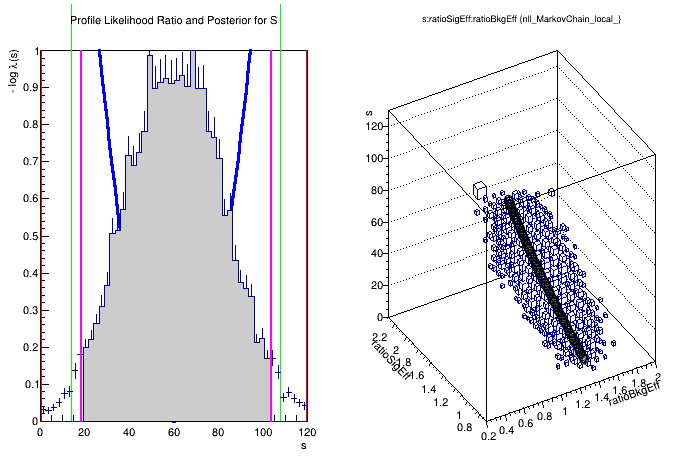

In [22]:
gROOT->GetListOfCanvases()->Draw()